In [1]:
# Necessary imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import argparse

from torch import Tensor

from qiskit import Aer, QuantumCircuit, BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs
from qiskit.aqua.utils.dataset_helper import get_feature_dimension

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from quantic.data import DatasetLoader
    
# Additional torch-related imports
from torch import no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim # Adam, SGD, LBFGS
from torch.nn import NLLLoss # CrossEntropyLoss, MSELoss, L1Loss, BCELoss
from qnetworks import HybridQNN_Shallow
from qnetworks import HybridQNN

#time
import timeit


In [2]:
# network args
n_classes = 2
n_qubits = 2
n_features = None
if n_features is None:
    n_features = n_qubits
network = "hybridqnn_shallow" #hybridqnn_shallow
# train args
batch_size = 1
epochs = 10
LR = 0.001
n_samples_train = 200 #128
n_samples_test = 50 #64
# plot args
n_samples_show = batch_size
# dataset args
shuffle = True
dataset = "CIFAR100" # MNIST / CIFAR10 / CIFAR100, any from pytorch
dataset_cfg = ""
specific_classes_names = ["baby","man"] # ['0','1'] # selected (filtered) classes
print(specific_classes_names)
use_specific_classes = len(specific_classes_names)>=n_classes
# preprocessing
input_resolution = (28,28) #(28,28) # please check n_filts required on fc1/fc2 to input to qnn
resize_interpolation = transforms.functional.InterpolationMode.BILINEAR 

# Set seed for random generators
rand_seed = np.random.randint(50)
algorithm_globals.random_seed = rand_seed
manual_seed(rand_seed) # Set train shuffle seed (for reproducibility)

if not os.path.exists("plots"):
    os.mkdir("plots")

['bird', 'cat']


In [3]:


######## PREPARE DATASETS
time_start = timeit.timeit()

# Train Dataset
# -------------

if dataset_cfg:
    # Load a dataset configuration file
    dataset = DatasetLoader.load(from_cfg=dataset_cfg,framework='torchvision')
else:
    # Or instantate dataset manually
    dataset = DatasetLoader.load(dataset_type=dataset,
                                   num_classes=n_classes,
                                   specific_classes=specific_classes_names,
                                   num_samples_class_train=n_samples_train,
                                   num_samples_class_test=n_samples_test,
                                   framework='torchvision'
                                   )
print(f'Dataset partitions: {dataset.get_partitions()}')

X_train = dataset['train']
X_test = dataset['test']


# Get channels (rgb or grayscale)
if len(X_train.data.shape)>3: # 3d image (rgb+)
    n_channels = X_train.data.shape[3]
else: # 2d image (grayscale)
    n_channels = 1

if network == 'hybridqnn_shallow' or network == 'QSVM':
    # Set preprocessing transforms
    list_preprocessing = [
        transforms.Resize(input_resolution),
        transforms.ToTensor(),
    ] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
else:
    list_preprocessing = [
        transforms.Resize(input_resolution),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    ] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
X_train.transform= transforms.Compose(list_preprocessing)
X_test.transform = transforms.Compose(list_preprocessing)           

# set filtered/specific class names
classes_str = ",".join(dataset.specific_classes_names)
classes2spec = {}
specific_classes = dataset.specific_classes
for idx, class_idx in enumerate(specific_classes):
    classes2spec[class_idx]=idx

classes_list = dataset.classes
n_samples = n_samples_test

Files already downloaded and verified
Files already downloaded and verified
Dataset partitions: ['train', 'test']


In [4]:
# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=shuffle)
# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=shuffle)

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Dataloaders elapsed time: {time_elapsed} s")

Dataloaders elapsed time: 0.00048730603884905577 s


<Figure size 432x288 with 0 Axes>

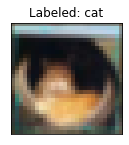

In [5]:
##### VISUALIZE LABELS
data_iter = iter(train_loader)
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    try:
        images, targets = data_iter.__next__()
    except:
        break
    plt.clf()
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for idx, image in enumerate(images):
        axes[idx].imshow(np.moveaxis(images[idx].numpy().squeeze(),0,-1))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        class_label = classes_list[targets[idx].item()]
        axes[idx].set_title("Labeled: {}".format(class_label))
        if idx > n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_labeled_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            break
    plt.show()
    n_samples_show_alt -= 1
    

In [6]:
##### DESIGN NETWORK
time_start = timeit.timeit()



# init network
if network == "hybridqnn_shallow":
    ## predefine number of input filters to fc1 and fc2
    # examples: 13456 for (128x128x1), 59536 for (256x256x1), 256 for (28x28x1), 400 for (28x28x3) or (35x35x1) 
    if n_channels == 1:
        n_filts_fc1 = int(((((input_resolution[0]-4)/2)-4)/2)**2)*16
    else:
        #n_filts_fc1 = int(((((input_resolution[0])/2)-4)/2)**2)*16 # +7
        n_filts_fc1 = 256
    n_filts_fc2 = int(n_filts_fc1 / 4)

    # declare quantum instance
    qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
    # Define QNN
    feature_map = ZZFeatureMap(n_features)
    ansatz = RealAmplitudes(n_qubits, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        n_qubits, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
    )
    print(qnn.operator)
    qnn.circuit.draw(output="mpl",filename=f"plots/qnn{n_qubits}_{n_classes}classes.png")
    #from qiskit.quantum_info import Statevector
    #from qiskit.visualization import plot_bloch_multivector
    #state = Statevector.from_instruction(qnn.circuit)
    #plot_bloch_multivector(state)
    model = HybridQNN_Shallow(n_classes = n_classes, n_qubits = n_qubits, n_channels = n_channels, n_filts_fc1 = n_filts_fc1, n_filts_fc2 = n_filts_fc2, qnn = qnn)
    print(model)

    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_func = NLLLoss()

elif network == "QSVM":
    backend = BasicAer.get_backend('qasm_simulator')

    # todo: fix this transformation for QSVM
    train_input = X_train.targets
    test_input = X_test.targets
    total_array = np.concatenate([test_input[k] for k in test_input])
    #
    feature_map = ZZFeatureMap(feature_dimension=get_feature_dimension(train_input),
                               reps=2, entanglement='linear')
    svm = QSVM(feature_map, train_input, test_input, total_array,
               multiclass_extension=AllPairs())
    quantum_instance = QuantumInstance(backend, shots=1024,
                                       seed_simulator=algorithm_globals.random_seed,
                                       seed_transpiler=algorithm_globals.random_seed)
else:
    model = HybridQNN(backbone=network,pretrained=True,n_qubits=n_qubits,n_classes=n_classes)
    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.network.parameters(), lr=LR)
    loss_func = NLLLoss()
    
time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Network init elapsed time: {time_elapsed} s")

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])
HybridQNN_Shallow(
  (conv1): Conv2d(3, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)
Network init elapsed time: -0.00020319299073889852 s


Batch 0, Loss: -1.69571852684021
Batch 1, Loss: -1.6487139463424683
Batch 2, Loss: 0.7358797788619995
Batch 3, Loss: -1.7580547332763672
Batch 4, Loss: -1.778651237487793
Batch 5, Loss: -1.7530670166015625
Batch 6, Loss: 0.7879904508590698
Batch 7, Loss: 0.755623459815979
Batch 8, Loss: 0.7625733613967896
Batch 9, Loss: 0.7713145613670349
Batch 10, Loss: 0.7422940731048584
Batch 11, Loss: 0.712405800819397
Batch 12, Loss: 0.5321309566497803
Batch 13, Loss: -1.751202940940857
Batch 14, Loss: 0.7717148065567017
Batch 15, Loss: 0.6668925285339355
Batch 16, Loss: 0.6419951915740967
Batch 17, Loss: 0.6644410490989685
Batch 18, Loss: -0.25409021973609924
Batch 19, Loss: -1.5768399238586426
Batch 20, Loss: -1.0603878498077393
Batch 21, Loss: -0.20601600408554077
Batch 22, Loss: 0.22541527450084686
Batch 23, Loss: -0.21384963393211365
Batch 24, Loss: -1.363715648651123
Batch 25, Loss: -0.04642084240913391
Batch 26, Loss: -1.5241427421569824
Batch 27, Loss: -0.2329661250114441
Batch 28, Loss: 0

Batch 27, Loss: -1.3753647804260254
Batch 28, Loss: -0.8260995745658875
Batch 29, Loss: 0.8442463874816895
Batch 30, Loss: 0.7105922698974609
Batch 31, Loss: -1.4181594848632812
Batch 32, Loss: -0.041972219944000244
Batch 33, Loss: -0.17629936337471008
Batch 34, Loss: 0.7450137734413147
Batch 35, Loss: -0.8418177962303162
Batch 36, Loss: -0.23969551920890808
Batch 37, Loss: -0.9491525888442993
Batch 38, Loss: 0.31058913469314575
Batch 39, Loss: -0.8611063957214355
Batch 40, Loss: -0.004779160022735596
Batch 41, Loss: -1.282116413116455
Batch 42, Loss: 0.505250096321106
Batch 43, Loss: 0.25320515036582947
Batch 44, Loss: 0.44062453508377075
Batch 45, Loss: -1.393799901008606
Batch 46, Loss: 0.19396178424358368
Batch 47, Loss: -0.8991267681121826
Batch 48, Loss: -1.7257373332977295
Batch 49, Loss: -1.1958811283111572
Batch 50, Loss: -0.8517293334007263
Batch 51, Loss: -0.08286809921264648
Batch 52, Loss: 0.7371542453765869
Batch 53, Loss: 0.46092522144317627
Batch 54, Loss: 0.09227719902

Batch 54, Loss: -1.8353852033615112
Batch 55, Loss: -0.3489784896373749
Batch 56, Loss: 0.8295214772224426
Batch 57, Loss: -0.2310340404510498
Batch 58, Loss: -1.401787281036377
Batch 59, Loss: -1.731539011001587
Batch 60, Loss: 0.20562191307544708
Batch 61, Loss: -1.9310014247894287
Batch 62, Loss: 0.256043016910553
Batch 63, Loss: 0.5417416095733643
Batch 64, Loss: -1.1439805030822754
Batch 65, Loss: -0.964878261089325
Batch 66, Loss: -0.7807037830352783
Batch 67, Loss: -2.0155575275421143
Batch 68, Loss: 0.11636525392532349
Batch 69, Loss: -1.8148305416107178
Batch 70, Loss: -0.0877552330493927
Batch 71, Loss: -0.8314628601074219
Batch 72, Loss: 0.13363522291183472
Batch 73, Loss: -1.428256869316101
Batch 74, Loss: -1.0614047050476074
Batch 75, Loss: 0.9854392409324646
Batch 76, Loss: -1.2170524597167969
Batch 77, Loss: -1.8751415014266968
Batch 78, Loss: 0.14634490013122559
Batch 79, Loss: -0.8087342977523804
Batch 80, Loss: -1.2962584495544434
Batch 81, Loss: -0.8815497756004333
B

Batch 81, Loss: -1.4794447422027588
Batch 82, Loss: 0.2652294337749481
Batch 83, Loss: 0.44308552145957947
Batch 84, Loss: -1.0082870721817017
Batch 85, Loss: -0.23818683624267578
Batch 86, Loss: 0.5827975869178772
Batch 87, Loss: -0.9172096252441406
Batch 88, Loss: -1.5343999862670898
Batch 89, Loss: -0.8796464204788208
Batch 90, Loss: 0.7560418844223022
Batch 91, Loss: 0.7535854578018188
Batch 92, Loss: -1.310606837272644
Batch 93, Loss: 1.1439883708953857
Batch 94, Loss: -1.009643793106079
Batch 95, Loss: -1.6795353889465332
Batch 96, Loss: -1.336714744567871
Batch 97, Loss: 0.5228626728057861
Batch 98, Loss: 0.5595590472221375
Batch 99, Loss: -1.5475386381149292
Batch 100, Loss: -1.0366723537445068
Batch 101, Loss: -1.3349239826202393
Batch 102, Loss: 0.4576987326145172
Batch 103, Loss: -0.6696393489837646
Batch 104, Loss: -1.2967066764831543
Batch 105, Loss: -1.354691505432129
Batch 106, Loss: -0.08176225423812866
Batch 107, Loss: 0.01366385817527771
Batch 108, Loss: 0.49919116497

Batch 108, Loss: 0.003951221704483032
Batch 109, Loss: -1.5870296955108643
Batch 110, Loss: 0.459808349609375
Batch 111, Loss: -0.23414325714111328
Batch 112, Loss: -1.534226894378662
Batch 113, Loss: -1.5063676834106445
Batch 114, Loss: -1.7980636358261108
Batch 115, Loss: 1.042977213859558
Batch 116, Loss: -1.9625848531723022
Batch 117, Loss: 0.8671990633010864
Batch 118, Loss: 0.7376227378845215
Batch 119, Loss: -1.1883485317230225
Batch 120, Loss: -1.8976057767868042
Batch 121, Loss: -0.9463092088699341
Batch 122, Loss: 0.9047070741653442
Batch 123, Loss: 0.0563390851020813
Batch 124, Loss: -0.2159554660320282
Batch 125, Loss: -1.7182848453521729
Batch 126, Loss: 0.464849054813385
Batch 127, Loss: 0.3501140773296356
Batch 128, Loss: 0.5913000106811523
Batch 129, Loss: 0.060279011726379395
Batch 130, Loss: -1.7970938682556152
Batch 131, Loss: 0.7414095997810364
Batch 132, Loss: -2.1526741981506348
Batch 133, Loss: -2.0984320640563965
Batch 134, Loss: 0.7962042093276978
Batch 135, Lo

Batch 134, Loss: -0.7397053241729736
Batch 135, Loss: -2.0785720348358154
Batch 136, Loss: 0.15966098010540009
Batch 137, Loss: -1.7426812648773193
Batch 138, Loss: -1.8408770561218262
Batch 139, Loss: -1.9866220951080322
Batch 140, Loss: -1.2666515111923218
Batch 141, Loss: -1.5469986200332642
Batch 142, Loss: 0.8262220025062561
Batch 143, Loss: -1.6971226930618286
Batch 144, Loss: -1.7882331609725952
Batch 145, Loss: -1.7380577325820923
Batch 146, Loss: -1.786595106124878
Batch 147, Loss: -0.24372515082359314
Batch 148, Loss: -0.2918112874031067
Batch 149, Loss: 0.19613435864448547
Batch 150, Loss: -1.7360702753067017
Batch 151, Loss: -1.7813435792922974
Batch 152, Loss: -1.5262526273727417
Batch 153, Loss: 0.1468021124601364
Batch 154, Loss: 0.5856844186782837
Batch 155, Loss: -1.3031295537948608
Batch 156, Loss: -1.1895493268966675
Batch 157, Loss: 0.5072306394577026
Batch 158, Loss: 1.065739631652832
Batch 159, Loss: 0.924910306930542
Batch 160, Loss: -1.7783203125
Batch 161, Loss

Batch 160, Loss: 0.4069010615348816
Batch 161, Loss: -0.27722716331481934
Batch 162, Loss: -1.0661990642547607
Batch 163, Loss: 0.26811617612838745
Batch 164, Loss: -1.5040807723999023
Batch 165, Loss: -0.8839774131774902
Batch 166, Loss: -0.0659366250038147
Batch 167, Loss: -0.8512389659881592
Batch 168, Loss: -0.7088226079940796
Batch 169, Loss: 0.4137575924396515
Batch 170, Loss: -1.3767422437667847
Batch 171, Loss: -1.0439181327819824
Batch 172, Loss: -0.6724684238433838
Batch 173, Loss: 0.6326903700828552
Batch 174, Loss: -1.519978642463684
Batch 175, Loss: 0.23624086380004883
Batch 176, Loss: 0.0035800039768218994
Batch 177, Loss: -0.04050725698471069
Batch 178, Loss: -0.30053335428237915
Batch 179, Loss: -0.02552485466003418
Batch 180, Loss: -0.20070794224739075
Batch 181, Loss: 0.22805574536323547
Batch 182, Loss: -1.7598936557769775
Batch 183, Loss: 0.39306387305259705
Batch 184, Loss: -1.0676363706588745
Batch 185, Loss: -1.379789113998413
Batch 186, Loss: -1.4122852087020874

Batch 186, Loss: 0.8749875426292419
Batch 187, Loss: -1.7081812620162964
Batch 188, Loss: -1.645730972290039
Batch 189, Loss: -0.21863552927970886
Batch 190, Loss: -0.16988927125930786
Batch 191, Loss: -0.7460868954658508
Batch 192, Loss: 0.3794518709182739
Batch 193, Loss: 0.042885273694992065
Batch 194, Loss: 0.5446254014968872
Batch 195, Loss: -0.936163067817688
Batch 196, Loss: 0.2750084698200226
Batch 197, Loss: -1.879728078842163
Batch 198, Loss: -1.820500135421753
Batch 199, Loss: -1.6207411289215088
Training [80%]	Loss: -0.5284
Batch 0, Loss: 0.6755095720291138
Batch 1, Loss: 0.2590499222278595
Batch 2, Loss: -0.8962280750274658
Batch 3, Loss: -0.017961442470550537
Batch 4, Loss: 0.5142378807067871
Batch 5, Loss: -0.24418097734451294
Batch 6, Loss: -0.31730368733406067
Batch 7, Loss: -0.8203319311141968
Batch 8, Loss: -1.3594214916229248
Batch 9, Loss: -0.22130638360977173
Batch 10, Loss: 0.2893306016921997
Batch 11, Loss: 0.8330403566360474
Batch 12, Loss: -1.833265781402588
B

Batch 12, Loss: 0.7570005059242249
Batch 13, Loss: -1.7917559146881104
Batch 14, Loss: -1.9255471229553223
Batch 15, Loss: -1.8000603914260864
Batch 16, Loss: -0.3141798973083496
Batch 17, Loss: -0.7988367676734924
Batch 18, Loss: -1.5346646308898926
Batch 19, Loss: -1.8004494905471802
Batch 20, Loss: 0.8051635026931763
Batch 21, Loss: -0.41062691807746887
Batch 22, Loss: -1.7729671001434326
Batch 23, Loss: -0.7693297266960144
Batch 24, Loss: -0.9701888561248779
Batch 25, Loss: -1.8290040493011475
Batch 26, Loss: -0.5831260681152344
Batch 27, Loss: -0.9049161076545715
Batch 28, Loss: -0.29747986793518066
Batch 29, Loss: 0.5455161333084106
Batch 30, Loss: 0.9344378709793091
Batch 31, Loss: -1.7135467529296875
Batch 32, Loss: -2.1499226093292236
Batch 33, Loss: -0.6777257919311523
Batch 34, Loss: -2.2250118255615234
Batch 35, Loss: -1.8608052730560303
Batch 36, Loss: -1.0010570287704468
Batch 37, Loss: -1.6849920749664307
Batch 38, Loss: 0.22826530039310455
Batch 39, Loss: -0.80508708953

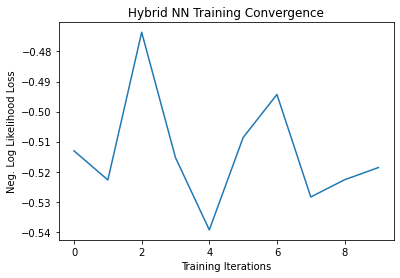

Training time: -0.000651123933494091 s


In [7]:
################# TRAIN
# Start training
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.train()  # Set model to training mode
    if network == "hybridqnn_shallow":
        model.train()  # Set model to training mode
        
    loss_list = []  # Store loss history
    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = model(data)  # Forward pass
            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            loss = loss_func(output, target)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss.append(loss.item())  # Store loss
            print(f"Batch {batch_idx}, Loss: {total_loss[-1]}")
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

    # Plot loss convergence
    plt.clf()
    plt.plot(loss_list)
    plt.title("Hybrid NN Training Convergence")
    plt.xlabel("Training Iterations")
    plt.ylabel("Neg. Log Likelihood Loss")
    #plt.savefig(f"plots/{dataset}_classification{classes_str}_hybridqnn_q{n_qubits}_{n_samples}samples_lr{LR}_bsize{batch_size}.png")
    plt.show()
    
elif network == "QSVM":
    result = svm.run(quantum_instance)
    for k,v in result.items():
        print(f'{k} : {v}')

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Training time: {time_elapsed} s")

In [8]:
######## TEST
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.eval()  # Set model to eval mode
    if network == "hybridqnn_shallow":
        model.eval()  # Set model to eval mode
    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)
            pred = output.argmax(dim=1, keepdim=True)

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
            )
        )

    time_end = timeit.timeit()
    time_elapsed = time_end - time_start
    print(f"Test time: {time_elapsed} s")
    
    


Performance on test data:
	Loss: -0.5115
	Accuracy: 50.0%
Test time: -0.00019305397290736437 s


<Figure size 432x288 with 0 Axes>

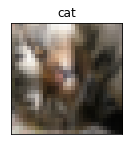

In [9]:
# Plot predicted labels
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    plt.clf()
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for batch_idx, (data, target) in enumerate(test_loader):    
        if count == n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_pred_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            plt.show()
            break
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        for sample_idx in range(batch_size):
            try:
                class_label = classes_list[specific_classes[pred[sample_idx].item()]]
            except:
                class_label = classes_list[specific_classes[pred[sample_idx].item()-1]]
            axes[count].imshow(np.moveaxis(data[sample_idx].numpy().squeeze(),0,-1))
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title(class_label)
            count += 1
    n_samples_show_alt -= 1

### 